# Taiwan Company Profile Bankruptcy Prediction
In this notebook we analyze information from the Taiwan Stock Exchange, including 95 features and 6819 rows representing the various listed companies.

First we do some standard EDA and data prep, then we build some baseline models for Logistic Regression, XGBooost and Random Forest models. Then we circle back and tune our hyperparameters with some iterations using either grid or randomized searches. Then we look at the results of our algorithm tuning, think about the business case, and suggest a best model or course of action.

The results of this analysis suggested using both logistic regression and XGBoost in a simple two-model ensemble. Our Logistic Regression model had better recall, while our XGBoost model had a better F1 score and precision.

Note that in this circumstance a common mistake is to oversample test data with SMOTE. Doing this gives a highly inflated F1 score because of the class imbalance in the dataset. Part of the difficulty in this set is to correctly classify the test data despite its significant class imbalance.

In [254]:
# First we'll import relevant packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [255]:
# Loading the data
df = pd.read_csv('Bankruptcy_Detection/data.csv')

In [256]:
# EDA Block
df = df

display(df.shape)
print()
display(df.head(3))
print()
display(df.describe())

(6819, 96)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


It looks like maybe Net Income Flag is a useless feature, and some of our other features look very skewed - equity to liability and liability to equity seem to have significant outliers. We'll get a better sense of this when we look at the histograms later. For now let's drop that useless column.

In [257]:
df.drop(columns=' Net Income Flag', inplace=True)

In [258]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

None

We can see here that much of our data preparation has been done for us. Great! Numbers are normalized and we have no missing values. The fact that our data is normalized means there will be some data leakage, as we will be performing our train-test-split after normalization. It looks like Liability-Assets Flag is a categorical column, that may need special treatment.

In [259]:
# Let's view the sorted correlation matrix of all of our features:
cor_plot = df.corr()
cor_plot = cor_plot.sort_values('Bankrupt?', ascending=False)
cor_plot.drop('Bankrupt?', axis=0, inplace=True)

# display(cor_plot.style.background_gradient(cmap = 'RdYlGn')) # All Correlations
pd.concat([cor_plot.head(10), cor_plot.tail(10)]).style.background_gradient(cmap = 'RdYlGn') # Just the top and bottom 10

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
Debt ratio %,0.250161,-0.261427,-0.259972,-0.264734,-0.245460,-0.245606,0.010397,-0.003906,-0.006174,-0.033214,-0.001192,0.143833,-0.045162,-0.285010,-0.059911,-0.009724,-0.249146,-0.249925,-0.249463,-0.177429,-0.158117,-0.019679,-0.078056,-0.158897,0.011461,-0.018100,-0.030240,-0.030512,-0.025205,-0.049191,0.056508,-0.001100,-0.134276,-0.015860,0.033410,0.023196,-0.054049,1.000000,-1.000000,-0.010523,0.329109,0.058862,-0.077250,-0.164110,0.417868,0.237458,0.029924,0.006062,-0.043629,-0.010258,0.436160,0.037412,0.007547,0.010321,-0.528797,-0.084232,0.109964,-0.357605,0.039455,0.082804,0.842583,-0.333429,0.002064,0.026934,-0.082322,-0.105008,0.343692,-0.006936,-0.235423,-0.027995,0.037513,0.124880,0.203370,-0.031715,0.138934,-0.018201,0.023418,-0.082322,0.343692,0.244974,-0.066502,-0.076983,-0.268159,-0.003178,0.428180,0.203155,-0.281422,0.041055,-0.050218,-0.245461,-0.123986,0.349250,0.017982,0.012571,-0.625879
Current Liability to Assets,0.194494,-0.210256,-0.190501,-0.217186,-0.198027,-0.197842,0.011340,0.001632,-0.002805,-0.024357,0.000159,0.135256,-0.046075,-0.278218,-0.041390,0.038520,-0.198546,-0.199086,-0.198721,-0.097689,-0.147717,-0.026361,-0.003496,-0.079795,0.021559,-0.006721,-0.021936,-0.022080,-0.016883,-0.069315,0.024605,0.016977,-0.138271,-0.012141,0.048153,0.006254,-0.045142,0.842583,-0.842583,0.036649,0.229825,

There's a lot going on in this correlation matrix, but it's pretty clear that no single feature is a perfect measure, and our model may have to incorporate many features to accurately predict bankruptcy.

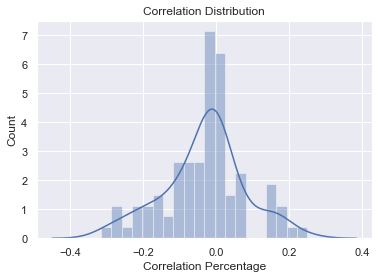

In [260]:
# Let's look at the distribution of correlation with our target
corr_graph = pd.concat([cor_plot.head(5), cor_plot.tail(5)])
fig1 = sns.distplot(cor_plot['Bankrupt?'], bins=20)
fig1.set_title('Correlation Distribution');
fig1.set_xlabel('Correlation Percentage');
fig1.set_ylabel('Count');

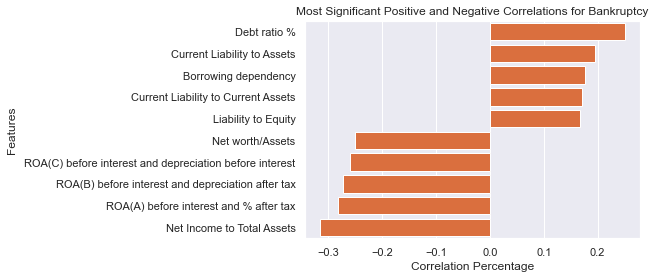

In [261]:
# And now let's see a visualization of our top and bottom 5 correlators
fig2 = sns.barplot(y=corr_graph.index,
                  x=corr_graph['Bankrupt?'],
                  orient='h',
                  color='#f46524');

sns.set(rc = {'figure.figsize': (8,8)})
fig2.set_title('Most Significant Positive and Negative Correlations for Bankruptcy');
fig2.set_xlabel('Correlation Percentage');
fig2.set_ylabel('Features');

This all gives us some interesting information - We can see that the biggest correlations (negative or positive) are the Net Income to Total Assets, ROA(A), ROA(B) and ROA(C) columns. Then we see Net worth/Assets and Debt Ratios. Our biggest single correlation still only accounts for about .31% of the cases however.

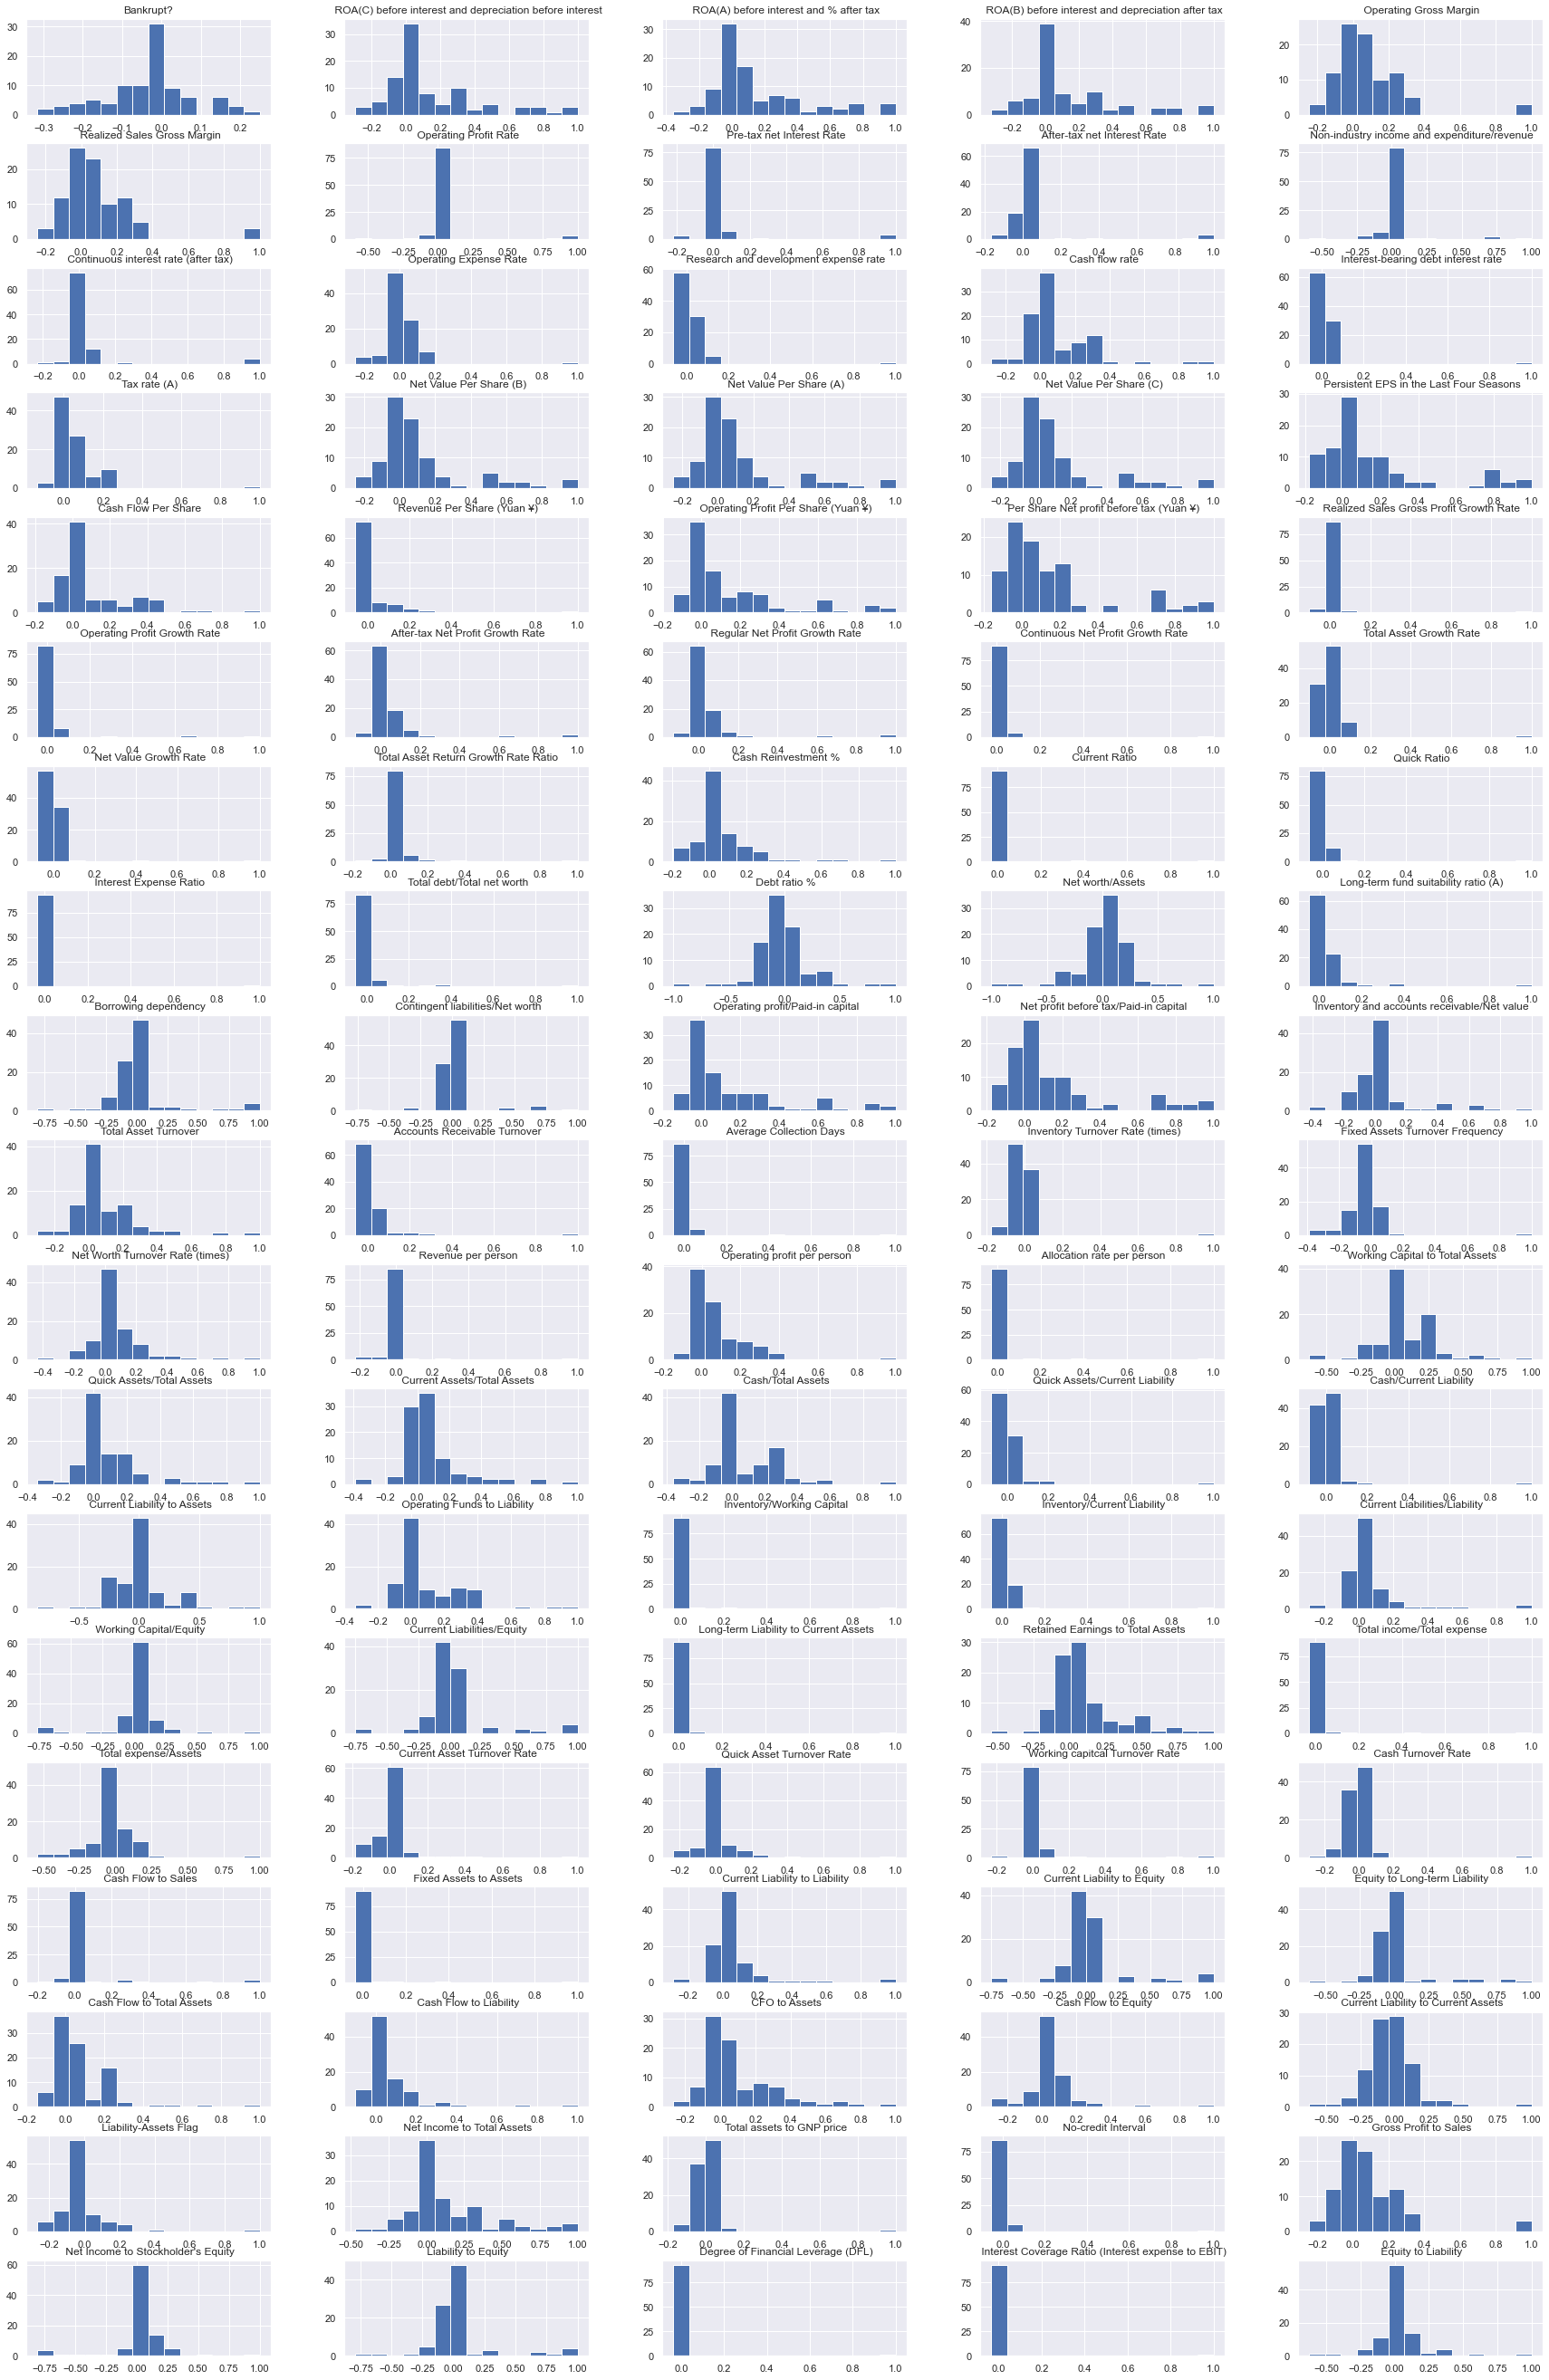

In [262]:
# Let's view the Histograms to understand how data is distributed.
cor_plot.hist(figsize=[30,50], bins=14, layout=[20, 5]);

Looking at our histograms, a couple features stand out. Many are very skewed with a few extreme outliers, such as "Interest Coverage Ratio" at the bottom. Let's investigate this further:

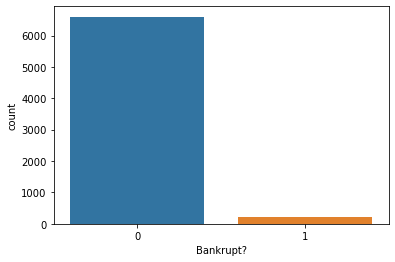

The class imbalance in the dataset is significant, with a target constituting only 3.2% of the data.


In [48]:
# Illustrating the Class Imbalance
plt.show(sns.countplot(x=df['Bankrupt?']))
class_imbalance = round(sum(df['Bankrupt?']) / len(df['Bankrupt?']), 3) * 100
print(f'The class imbalance in the dataset is significant, with a target constituting only {class_imbalance}% of the data.')

## Notes on EDA
The data seems well prepared and comes pre-normalized - all data is numeric and there are no missing values, so our data prep will be fairly minimal. The largest visible problem is that we have a significant class-imbalance problem which will need to be corrected with some oversampling strategy -- for this we will use SMOTE. It's important to apply SMOTE only to the training data, otherwise our test data will be compromised, giving us innacurate predictions. In future implementation, we can't apply SMOTE to our target because we should expect our prediction target in new data to be unlabeled.

The other thing we could do at this stage is process any significant outliers. Since the data has come to us normalized, I've opted to skip this step.

In [49]:
# Assigning X and Y
X = df.drop(labels='Bankrupt?', axis=1)
y = df['Bankrupt?']

In [50]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Class Imbalance addresssed with SMOTENC:


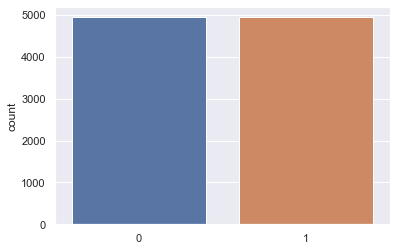

In [253]:
# Balancing class-imbalanced data with SMOTENC
sm = SMOTENC(categorical_features=[84], random_state=42)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train.ravel())
print('Class Imbalance addresssed with SMOTENC:')
sns.countplot(x=y_train_SMOTE);

Note that SMOTENC was used here - in testing, no difference was observed between SMOTE and SMOTENC, so SMOTENC was retained.

# Fitting Initial Models
Let's get some baseline models and compare their default outputs.

### Logistic Regression Baseline

In [201]:
log_reg=LogisticRegression()
log_reg.fit(X_train_SMOTE,y_train_SMOTE)

print('Training Accuracy: {:.4}%'.format(log_reg.score(X_train_SMOTE, y_train_SMOTE) * 100))
print('Validation accuracy: {:.4}%'.format(log_reg.score(X_test, y_test) * 100))

Training Accuracy: 61.91%
Validation accuracy: 76.72%


### XGBoost Baseline

In [237]:
# Instantiate and Fit an XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train_SMOTE, y_train_SMOTE)

# Accuracy of training and test sets
print('Training Accuracy: {:.4}%'.format(XGB.score(X_train_SMOTE, y_train_SMOTE) * 100))
print('Validation accuracy: {:.4}%'.format(XGB.score(X_test, y_test) * 100))

[14:12:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 100.0%
Validation accuracy: 96.6%


### Random Forest Baseline

In [203]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train_SMOTE, y_train_SMOTE)

# Training and Testing accuracy score
print('Training Accuracy: {:.4}%'.format(forest.score(X_train_SMOTE, y_train_SMOTE) * 100))
print('Validation accuracy: {:.4}%'.format(forest.score(X_test, y_test) * 100))

Training Accuracy: 100.0%
Validation accuracy: 95.37%


# Model Validation

In [204]:
# Comparing all three models
print('LogReg Validation set Accuracy:  {:.4}%'.format(log_reg.score(X_test, y_test) * 100))
print('XGBoost Validation set Accuracy: {:.4}%'.format(XGB.score(X_test, y_test) * 100))
print('Forest Validation set Accuracy:  {:.4}%'.format(forest.score(X_test, y_test) * 100))

log_pred=log_reg.predict(X_test)
XGB_pred=XGB.predict(X_test)
RF_pred=forest.predict(X_test)

print('\nLogistic Regression Report:')
print(classification_report(y_test, log_pred))
print('\nXGBoost Report:')
print(classification_report(y_test, XGB_pred))
print('\nRF Report:')
print(classification_report(y_test, RF_pred))

LogReg Validation set Accuracy:  76.72%
XGBoost Validation set Accuracy: 96.6%
Forest Validation set Accuracy:  95.37%

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1650
           1       0.05      0.33      0.08        55

    accuracy                           0.77      1705
   macro avg       0.51      0.55      0.47      1705
weighted avg       0.94      0.77      0.84      1705


XGBoost Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1650
           1       0.47      0.44      0.45        55

    accuracy                           0.97      1705
   macro avg       0.73      0.71      0.72      1705
weighted avg       0.96      0.97      0.97      1705


RF Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1650
           1       0.34      0.47      0.40        55

    a

Our baselines are showing superior performances for our XGBoost and Random Forest, but because of our class imbalance issue, accuracy is not a good measure of performance. Instead we should probably use F1 score and measure how many times the target is correctly classified.

In [205]:
print('Baseline Models with Default Parameters:\n')
print('Logistic Regression F1:')
print(f1_score(y_test, log_pred))
print('\nXGB F1:')
print(f1_score(y_test, XGB_pred))
print('\nRF F1:')
print(f1_score(y_test, RF_pred))

Baseline Models with Default Parameters:

Logistic Regression F1:
0.08314087759815242

XGB F1:
0.45283018867924524

RF F1:
0.3969465648854962


Looking at our F1 scores, there's probably some room for improvement. The other thing we can do is consider the coefficients and importance of features by looking inside the box of our Logistic Regression model.

In [206]:
coef = log_reg.coef_[0]
logreg_coef = pd.DataFrame(coef, 
             X_train_SMOTE.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)
logreg_coef

,coef
Fixed Assets to Assets,4.676691e-09
Total debt/Total net worth,6.398740e-10
Cash/Current Liability,4.369849e-10
Total assets to GNP price,3.316464e-10
Quick Ratio,2.668686e-10
...,...
Quick Assets/Current Liability,-9.782383e-10
Allocation rate per person,-1.640843e-09
Average Collection Days,-3.285532e-09
Accounts Receivable Turnover,-4.407170e-09


We can see here that our coefficients are very small - perhaps this is due to the normalized data? Still, we can get a sense of the most important features, such as "fixed assets to assets", "accounts receivable turnover", and "interest-bearing debt interest rate". This is all pretty interesting information, as it tells us which predictors are most important to our model.

The next thing we will do is tune the hyperparameters of each model and look again at our F1 scores.

# Hyperparameter Tuning

First let's decide what metrics our tuning should measure and optimize for. We'll keep tabs on accuracy, but optimize our model for f1.

In [207]:
measure = ['accuracy','f1']
optimize = 'f1'

Now we'll run hyperparameter searches on each of our previous models. This can be a long iterative process, some iterations have been hidden for brevity.

### Logistic Regression Hyperparameter Tuning

In [208]:
# Our hyperparameter grid

logreg_params = {
    "C" : [1], # 0.01, 0.1
    'class_weight': ['balanced'],
    "penalty" : ["l1"], # 'l2'
    'solver':['liblinear']
}

# Searching Parameters
tuned_logreg = GridSearchCV(log_reg, logreg_params, scoring=optimize, cv=3, n_jobs=1)
tuned_logreg.fit(X_train_SMOTE, y_train_SMOTE)

logreg_best_params = tuned_logreg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(logreg_best_params.keys()):
    print('%s: %r' % (param_name, logreg_best_params[param_name]))

Grid Search found the following optimal parameters: 
C: 1
class_weight: 'balanced'
penalty: 'l1'
solver: 'liblinear'


In [251]:
# Grid Search Results
grid_results = pd.concat([pd.DataFrame(tuned_logreg.cv_results_["params"]),pd.DataFrame(tuned_logreg.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
display(grid_results.head())

# Comparison to Baseline
Tlogreg_pred=tuned_logreg.predict(X_test)
print('Baseline Logistic Regression F1: ' + str(f1_score(y_test, log_pred)))
print('Tuned Logistic Regression F1: ' + str(f1_score(y_test, Tlogreg_pred)))

,C,class_weight,penalty,solver,Accuracy
0,1,balanced,l1,liblinear,0.906559


Baseline Logistic Regression F1: 0.08314087759815242
Tuned Logistic Regression F1: 0.3333333333333333


### XGBoost Hyperparameter Tuning

In [239]:
# Our hyperparameter grid, with some other options as comments

XGB_params = {
#     'learning_rate' : [0.2, 0.25, 0.3, 0.35],
    'min_child_weight' : [0],
#     'gamma' : [0.0, 0.1, 0.2 , 0.3, 0.4],
#     'colsample_bytree' : [0.3, 0.4, 0.5 , 0.7],
    'alpha' : [0.01], # L1 regularization
#     'eta': [1, 0.1, 0.01,],
    'eval_metric':['mlogloss'],
    'lambda':[1], # L2 regularization
#     'booster' : ['gbtree', 'gblinear', 'dart'],
    'max_depth': [4, 6, None],
    'n_estimators': [120, 180],
#     'scale_pos_weight' : [.9, 1, 1.1] # deals with imbalanced data - not needed since training data is oversampled 
#     'subsample': [0.5]
}

# Searching Parameters
tuned_XGB = GridSearchCV(XGB, XGB_params, scoring=optimize, cv=3, n_jobs=1)
tuned_XGB.fit(X_train_SMOTE, y_train_SMOTE)

XGB_best_parameters = tuned_XGB.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(XGB_best_parameters.keys()):
    print('%s: %r' % (param_name, XGB_best_parameters[param_name]))

Grid Search found the following optimal parameters: 
alpha: 0.01
eval_metric: 'mlogloss'
lambda: 1
max_depth: 4
min_child_weight: 0
n_estimators: 180


In [250]:
# Grid Search Results
grid_results = pd.concat([pd.DataFrame(tuned_XGB.cv_results_["params"]),pd.DataFrame(tuned_XGB.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
display(grid_results.head())

# Comparison to Baseline
TXGB_pred=tuned_XGB.predict(X_test)
print('Baseline XGBoost F1: ' + str(f1_score(y_test, XGB_pred)))
print('Tuned XGB F1: ' + str(f1_score(y_test, TXGB_pred)))

,alpha,eval_metric,lambda,max_depth,min_child_weight,n_estimators,Accuracy
0,0.01,mlogloss,1,4.0,0,120,0.985525
1,0.01,mlogloss,1,4.0,0,180,0.986325
2,0.01,mlogloss,1,4.0,3,120,0.984030
3,0.01,mlogloss,1,4.0,3,180,0.985120
4,0.01,mlogloss,1,6.0,0,120,0.983858


Baseline XGBoost F1: 0.45283018867924524
Tuned XGB F1: 0.5


### Random Forest Hyperparameter Tuning

In [217]:
# Our hyperparameter grid, with some other options as comments

rf_params = {
    'bootstrap' : [False],
    'class_weight' : ['balanced'], # 'balanced_subsample',
    'criterion' : ['entropy'], # 'gini', 
    'max_features' : ['auto'],
    'max_depth' : [3, 5, 10, None],
    'n_estimators' : [100, 120, 140, 200, 300,]
}

# Searching parameters
tuned_rf = GridSearchCV(forest, rf_params, scoring=optimize, cv=3, n_jobs=1)
tuned_rf.fit(X_train_SMOTE, y_train_SMOTE)

rf_best_params = tuned_rf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(rf_best_params.keys()):
    print('%s: %r' % (param_name, rf_best_params[param_name]))

Grid Search found the following optimal parameters: 
bootstrap: False
class_weight: 'balanced'
criterion: 'entropy'
max_depth: None
max_features: 'auto'
n_estimators: 200


In [249]:
# Grid Search Results
grid_results = pd.concat([pd.DataFrame(tuned_rf.cv_results_["params"]),pd.DataFrame(tuned_rf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
display(grid_results.head())

# Comparison to Baseline
TRF_pred=tuned_rf.predict(X_test)
print('Baseline Random Forest F1: ' + str(f1_score(y_test, RF_pred)))
print('Tuned Random Forest F1: ' + str(f1_score(y_test, TRF_pred)))

,bootstrap,class_weight,criterion,max_depth,max_features,n_estimators,Accuracy
0,False,balanced,entropy,3.0,auto,100,0.908246
1,False,balanced,entropy,3.0,auto,120,0.909358
2,False,balanced,entropy,3.0,auto,140,0.909137
3,False,balanced,entropy,3.0,auto,200,0.911182
4,False,balanced,entropy,3.0,auto,300,0.912207


Baseline Random Forest F1: 0.3969465648854962
Tuned Random Forest F1: 0.43103448275862066


# Hyperparameter Tuning Results
Now that we've tuned and fitted our three models, let's think about how they compare to one-another with some model evaluation. How do our new scores relate to our initial scores?

In [248]:
# Model overviews - classification reports
print('\nTuned Logistic Regression Report:')
print(classification_report(y_test, Tlogreg_pred))
print('\nTuned XGBoost Report:')
print(classification_report(y_test, TXGB_pred))
print('\nTuned RF Report:')
print(classification_report(y_test, TRF_pred))


Tuned Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1650
           1       0.21      0.84      0.33        55

    accuracy                           0.89      1705
   macro avg       0.60      0.87      0.64      1705
weighted avg       0.97      0.89      0.92      1705


Tuned XGBoost Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1650
           1       0.51      0.49      0.50        55

    accuracy                           0.97      1705
   macro avg       0.75      0.74      0.74      1705
weighted avg       0.97      0.97      0.97      1705


Tuned RF Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1650
           1       0.41      0.45      0.43        55

    accuracy                           0.96      1705
   macro avg       0.70      0.72      0.71      170

It's looking like XGBoost is the most precise, while Logistic Regression has fairly solid Recall.

In [243]:
# Interpreting results of our hyperparameter tuning
print('Tuned F1 Compared to Baseline:\n')
print('Baseline Logistic Regression F1: ' + str(f1_score(y_test, log_pred)))
print('Tuned Logistic Regression F1: ' + str(f1_score(y_test, Tlogreg_pred)))
print()
print('Baseline XGBoost F1: ' + str(f1_score(y_test, XGB_pred)))
print('Tuned XGB F1: ' + str(f1_score(y_test, TXGB_pred)))
print()
print('Baseline Random Forest F1: ' + str(f1_score(y_test, RF_pred)))
print('Tuned Random Forest F1: ' + str(f1_score(y_test, TRF_pred)))

Tuned F1 Compared to Baseline:

Baseline Logistic Regression F1: 0.08314087759815242
Tuned Logistic Regression F1: 0.3333333333333333

Baseline XGBoost F1: 0.45283018867924524
Tuned XGB F1: 0.5

Baseline Random Forest F1: 0.3969465648854962
Tuned Random Forest F1: 0.43103448275862066


We were able to sqeeze some improvement out of each model, with the logistic regression in particular showing a considerable improvement. Navigating the class imbalance in the test data remains difficult. How did we affect the overall accuracy?

In [252]:
# Accuracy Scores
print('Tuned Accuracy Scores compared to Baseline:\n')
print('LogReg Validation Accuracy:         {:.4}%'.format(log_reg.score(X_test, y_test) * 100))
print('Tuned LogReg Validation Accuracy:   {:.4}%'.format(tuned_logreg.best_score_*100))
print()
print('XGBoost Validation Accuracy:        {:.4}%'.format(XGB.score(X_test, y_test) * 100))
print('Tuned XGBoost Validation Accuracy:  {:.4}%'.format(tuned_XGB.best_score_*100))
print()
print('Forest Validation Accuracy:         {:.4}%'.format(forest.score(X_test, y_test) * 100))
print('Tuned Forest Validation Accuracy:   {:.4}%'.format(tuned_rf.best_score_*100))

Tuned Accuracy Scores compared to Baseline:

LogReg Validation Accuracy:         76.72%
Tuned LogReg Validation Accuracy:   90.66%

XGBoost Validation Accuracy:        96.6%
Tuned XGBoost Validation Accuracy:  98.63%

Forest Validation Accuracy:         95.37%
Tuned Forest Validation Accuracy:   98.22%


It looks like our model accuracy was not compromised, even though accuracy was not our scoring method in our hyperparameter tuning. Cool! Let's look at Precision and Recall with ROC curves and confusion matrices.

Logreg AUC: 86.52% -- False Positive Rate: 10.61% -- True Positive Rate: 83.64%
XGB AUC:    73.76% -- False Positive Rate: 1.58% -- True Positive Rate: 49.09%
RF AUC:     71.64% -- False Positive Rate: 2.18% -- True Positive Rate: 45.45%


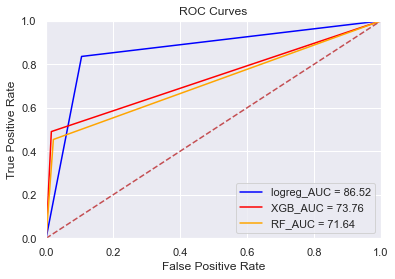

In [245]:
# ROC Curves for Tuned Sets
logreg_fp, logreg_tp, thresholds=roc_curve(y_test, Tlogreg_pred, pos_label=1)
logreg_AUC=auc(logreg_fp, logreg_tp)*100
print(f'Logreg AUC: {round(logreg_AUC, 2)}% -- False Positive Rate: {round(logreg_fp[1] * 100, 2)}% -- True Positive Rate: {round(logreg_tp[1] * 100, 2)}%')
plt.plot(logreg_fp, logreg_tp, color='blue',label = 'logreg_AUC = %0.2f' % logreg_AUC)

XGB_fp, XGB_tp, thresholds=roc_curve(y_test, TXGB_pred, pos_label=1)
XGB_AUC=auc(XGB_fp, XGB_tp)*100
print(f'XGB AUC:    {round(XGB_AUC, 2)}% -- False Positive Rate: {round(XGB_fp[1] * 100, 2)}% -- True Positive Rate: {round(XGB_tp[1] * 100, 2)}%')
plt.plot(XGB_fp, XGB_tp, color='red',label = 'XGB_AUC = %0.2f' % XGB_AUC)

RF_fp, RF_tp, thresholds=roc_curve(y_test, TRF_pred, pos_label=1)
RF_AUC=auc(RF_fp, RF_tp)*100
print(f'RF AUC:     {round(RF_AUC, 2)}% -- False Positive Rate: {round(RF_fp[1] * 100, 2)}% -- True Positive Rate: {round(RF_tp[1] * 100, 2)}%')
plt.plot(RF_fp, RF_tp, color='orange',label = 'RF_AUC = %0.2f' % RF_AUC)

plt.title('ROC Curves')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

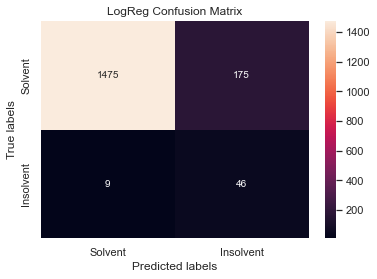

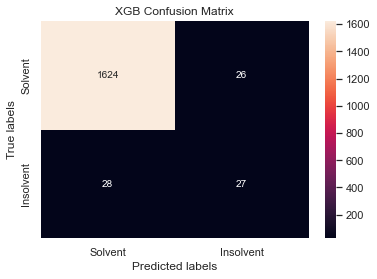

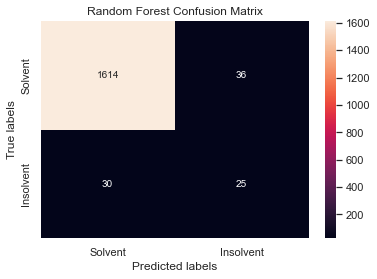

In [246]:
# Tuned Confusion Matrices
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, Tlogreg_pred), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('LogReg Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Solvent', 'Insolvent']); ax.yaxis.set_ticklabels(['Solvent', 'Insolvent']);
plt.show(ax)

ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, TXGB_pred), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('XGB Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Solvent', 'Insolvent']); ax.yaxis.set_ticklabels(['Solvent', 'Insolvent']);
plt.show(ax)

ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, TRF_pred), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); ax.set_title('Random Forest Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Solvent', 'Insolvent']); ax.yaxis.set_ticklabels(['Solvent', 'Insolvent']);
plt.show(ax)

# Final Model Selection
This is an interesting result - Even though Logistic Regression was the least accurate model we tested, it has the best Recall Score and Area Under the Curve. Depending on our goal, this may be the best option for us to flag potential companies earlier, with our XGboost or Random Forest models as more precise, less inclusive alternatives.

For that reason I recommend a simple two-model ensemble, where our logistic regression model is enough to raise flags and our XGboost model increases the confidence level of these flags.

In [247]:
print('\nTuned Logistic Regression Report:')
print(classification_report(y_test, Tlogreg_pred))
print('\nTuned XGBoost Report:')
print(classification_report(y_test, TXGB_pred))


Tuned Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1650
           1       0.21      0.84      0.33        55

    accuracy                           0.89      1705
   macro avg       0.60      0.87      0.64      1705
weighted avg       0.97      0.89      0.92      1705


Tuned XGBoost Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1650
           1       0.51      0.49      0.50        55

    accuracy                           0.97      1705
   macro avg       0.75      0.74      0.74      1705
weighted avg       0.97      0.97      0.97      1705



---
---
---

# Closing Thoughts

In the future, a good next step would be to dive deeper into ROC curves and precision/recall tradeoffs and coordinate with stakeholders to determine a good balance for their application. It may be that XGBoost can be tuned for higher precision and recall than the logistic regression model.

Another good step would be to try other algorithms, like KNN or CATBoost, and see if they can outperform the above benchmarks.

In the future we could do more feature engineering to eliminate multicollinearity or unimportant dimensions in the algorithm. If we have access to unprocessed data, we might want to normalize after our train/test split to eliminate data leakage.

This analysis was performed by Blake McMeekin at https://github.com/thegrandblooms

---
---
---